In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import pickle
import sys

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from tqdm import tqdm

from torchvision import datasets, transforms
from sklearn.model_selection import StratifiedShuffleSplit

from functools import lru_cache

from sklearn.decomposition import PCA
from scipy.sparse.linalg import eigsh
from sklearn.decomposition._pca import _infer_dimension
from sklearn.utils.extmath import randomized_svd
from sklearn.mixture import GaussianMixture
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist


In [4]:
# Create a data loader
# choose MNIST or CIFAR-10 via task argument
class DataLoader:
    def __init__(self, task="mnist", batch_size=64, test_batch_size=256):
        self.task = task
        self.batch_size = batch_size
        self.test_batch_size = test_batch_size
        self.test_sample_limit = None

    def get_transforms(self):
        if self.task == "mnist":
            return transforms.Compose(
                [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
            )
        elif self.task == "cifar10":
            return transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))]
            )
        else:
            raise ValueError(f"Unsupported task: {self.task}")

    def load_data(self, data_dir=None):
        """Load the full dataset and create test loader."""
        if data_dir is None:
            data_dir = os.path.join(PROJECT_ROOT, "data")

        if self.task == "mnist":
            transform = self.get_transforms()
            train_set = datasets.MNIST(
                data_dir, train=True, download=True, transform=transform
            )
            test_set = datasets.MNIST(data_dir, train=False, transform=transform)
        elif self.task == "cifar10":
            transform = self.get_transforms()
            train_set = datasets.CIFAR10(
                data_dir, train=True, download=True, transform=transform
            )
            test_set = datasets.CIFAR10(
                data_dir, train=False, download=True, transform=transform
            )
        else:
            raise ValueError(f"Unsupported task: {self.task}")
        if self.test_sample_limit is not None:
            test_set = torch.utils.data.Subset(
                test_set, list(range(self.test_sample_limit))
            )

        test_loader = torch.utils.data.DataLoader(
            test_set, batch_size=self.test_batch_size, shuffle=False
        )
        return train_set, test_loader

    def get_train_loader(
        self, full_train_set, epoch=None, fewshot_samples=None, fewshot_batch_size=None
    ):
        """Get the appropriate train loader based on configuration.

        Args:
            full_train_set: The complete training dataset
            epoch: Current epoch number (for few-shot learning)
            fewshot_samples: Number of samples per class for few-shot learning
            fewshot_batch_size: Batch size for few-shot learning

        Returns:
            torch.utils.data.DataLoader: The training data loader
        """
        if fewshot_samples is not None:
            # Few-shot learning mode
            subset = self.create_fewshot_subset(full_train_set, epoch, fewshot_samples)
            return torch.utils.data.DataLoader(
                subset, batch_size=fewshot_batch_size or self.batch_size, shuffle=True
            )
        else:
            # Regular training mode
            return torch.utils.data.DataLoader(
                full_train_set, batch_size=self.batch_size, shuffle=True
            )


    def create_fewshot_subset(self, dataset, seed, samples_per_class=60):
        """Create a few-shot subset of the dataset.
        
        Args:
            dataset: The dataset to create a few-shot subset of
            seed: The seed for the random number generator
            samples_per_class: The number of samples per class in the few-shot subset

        Returns:
            torch.utils.data.Subset: The few-shot subset of the dataset
        """
        targets = np.array(dataset.targets)
        train_size = (samples_per_class * 10) / len(targets)
        sss = StratifiedShuffleSplit(
            n_splits=1, train_size=train_size, random_state=seed
        )
        indices, _ = next(sss.split(np.zeros_like(targets), targets))
        return torch.utils.data.Subset(dataset, indices)


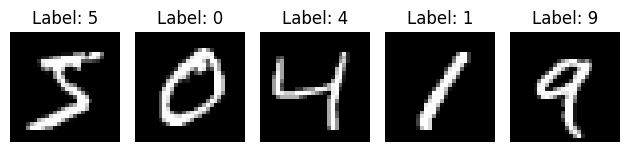

In [5]:
PROJECT_ROOT = os.path.dirname(os.path.dirname(os.getcwd()))
PROJECT_ROOT = os.path.abspath(os.path.join(PROJECT_ROOT, 'TNN_Image_Chess'))
batch_size = 64
data_loader = DataLoader(
     batch_size=batch_size, task="mnist"
)
train_set, test_loader = data_loader.load_data()
train_loader = data_loader.get_train_loader(train_set)

# show 5 sample images
for i in range(5):
    image, label = train_set[i]
    plt.subplot(1, 5, i + 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')
plt.tight_layout()
plt.show()



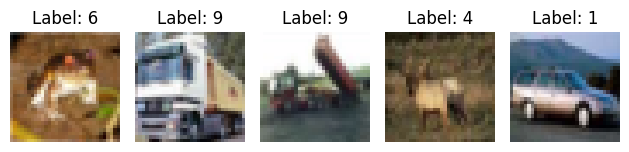

In [6]:
PROJECT_ROOT = os.path.dirname(os.path.dirname(os.getcwd()))
PROJECT_ROOT = os.path.abspath(os.path.join(PROJECT_ROOT, 'TNN_Image_Chess'))
batch_size = 64
data_loader = DataLoader(
     batch_size=batch_size, task="cifar10"
)
train_set, test_loader = data_loader.load_data()
train_loader = data_loader.get_train_loader(train_set)

# show 5 sample images
mean = np.array([0.4914, 0.4822, 0.4465])
std = np.array([0.2470, 0.2435, 0.2616])

for i in range(5):
    image, label = train_set[i]
    plt.subplot(1, 5, i + 1)
    image_np = image.numpy()
    image_np = np.transpose(image_np, (1, 2, 0))
    image_np = image_np * std + mean
    image_np = np.clip(image_np, 0, 1)
    plt.imshow(image_np)
    plt.title(f"Label: {label}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [10]:
def visualize_connectome_with_dots(
    connectivity_path, annotation_path, signed_path=None, output_path=None, dpi=300
):
    """Visualize connectome matrix using signed matrix to distinguish connection types and connectivity matrix to determine weights"""
    # Load connectivity matrix
    df_conn = pd.read_csv(connectivity_path, index_col=0)
    df_conn.index = df_conn.index.astype(int)
    df_conn.columns = df_conn.columns.astype(int)
    df_conn *= 0.04

    # Load annotation file
    df_annot = pd.read_csv(annotation_path)

    # Build mapping from cell type to neuron IDs
    cell_type_ids = {}
    neuron_types = {}
    for _, row in df_annot.iterrows():
        ct = row["celltype"]
        if ct not in cell_type_ids:
            cell_type_ids[ct] = []
        
        for side in ("left_id", "right_id"):
            s = str(row[side]).lower()
            if s not in ("nan", "no pair"):
                try:
                    nid = int(s)
                    if nid in df_conn.index:
                        cell_type_ids[ct].append(nid)
                        neuron_types[nid] = ct
                except ValueError:
                    pass

    # Remove duplicates and sort
    for ct in cell_type_ids:
        cell_type_ids[ct] = sorted(set(cell_type_ids[ct]))
    cell_types = sorted(cell_type_ids.keys())

    # Sort neuron IDs by cell type
    sorted_ids = []
    gb = {}
    current_idx = 0
    for ct in cell_types:
        start_idx = current_idx
        ids = cell_type_ids[ct]
        sorted_ids.extend(ids)
        current_idx += len(ids)
        gb[ct] = (start_idx, current_idx)

    # Extract sorted connectivity matrix
    W = df_conn.loc[sorted_ids, sorted_ids].values
    print("nonzero", np.sum(W != 0))

    # Read signed matrix to determine connection types (-1 for inhibitory, 1 for excitatory)
    if signed_path is not None:
        df_signed = pd.read_csv(signed_path, index_col=0)
        df_signed.index = df_signed.index.astype(int)
        df_signed.columns = df_signed.columns.astype(int)
        S = df_signed.loc[sorted_ids, sorted_ids].values
    else:
        S = np.sign(W)

    # Create figure
    fig, ax = plt.subplots(figsize=(16, 13))
    fig.subplots_adjust(left=0.12, right=0.75, top=0.90, bottom=0.12)

    # Collect connection data
    exc_x, exc_y, exc_w = [], [], []
    inh_x, inh_y, inh_w = [], [], []
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            w = W[i, j]  # Weight from connectivity matrix
            s = S[i, j]  # Connection type from signed matrix
            
            if w != 0:
                if s > 0:  # Excitatory connection (blue)
                    exc_x.append(j)
                    exc_y.append(i)
                    exc_w.append(abs(w))
                elif s < 0:  # Inhibitory connection (red)
                    inh_x.append(j)
                    inh_y.append(i)
                    inh_w.append(abs(w))

    # Calculate point sizes
    def sqrt_sizes(ws, min_s=2, max_s=30):
        if not ws:
            return []
        arr = np.array(ws)
        mn, mx = arr.min(), arr.max()
        if mx == mn:
            return [min_s] * len(ws)
        norm = (arr - mn) / (mx - mn)
        return (min_s + (max_s - min_s) * np.sqrt(norm)).tolist()

    exc_s = sqrt_sizes(exc_w)
    inh_s = sqrt_sizes(inh_w)

    # Plot scatter points
    if exc_s:
        ax.scatter(exc_x, exc_y, s=exc_s, color="#348ABD", alpha=0.8)
    if inh_s:
        ax.scatter(inh_x, inh_y, s=inh_s, color="#E24A33", alpha=0.8)

    # Draw cell type separator lines
    for ct, (start, _) in gb.items():
        if start > 0:
            ax.axhline(start - 0.5, color='grey', linewidth=2, alpha=0.7, linestyle='--')
            ax.axvline(start - 0.5, color='grey', linewidth=2, alpha=0.7, linestyle='--')

    # Set axis labels
    ax.set_xlabel("Postsynaptic Neurons", fontsize=52, labelpad=30)
    ax.set_ylabel("Presynaptic Neurons", fontsize=52, labelpad=30)
    
    # Hide axis numbers
    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params(top=False, right=False, left=False, bottom=False)

    type_handles = [
        Line2D([0],[0], marker="o", color="w", label="Inhibitory",
            markerfacecolor="#E24A33", markeredgecolor="#E24A33", markersize=10, linestyle="None"),
        Line2D([0],[0], marker="o", color="w", label="Excitatory",
            markerfacecolor="#348ABD", markeredgecolor="#348ABD", markersize=10, linestyle="None"),
    ]
    legend1 = fig.legend(
        handles=type_handles,
        title="Type",
        title_fontsize=40,
        fontsize=36,
        loc="upper left",
        bbox_to_anchor=(0.8, 0.72),
        frameon=False,
        facecolor="none",
        borderaxespad=0,
        handletextpad=0.5,
    )

    # weight legend
    samples = [25, 50, 75, 100]
    szs = sqrt_sizes([w * 0.04 for w in samples])
    weight_handles = [
        ax.scatter([], [], s=sz, alpha=0.7)
        for sz in szs
    ]
    weight_labels = [f"{w}" for w in samples]
    legend2 = fig.legend(
        handles=weight_handles,
        labels=weight_labels,
        title="Weight",
        title_fontsize=40,
        fontsize=36,
        loc="upper left",
        bbox_to_anchor=(0.8, 0.52),
        frameon=False,
        facecolor="none",
        borderaxespad=0,
        handletextpad=0.5,
    )

    legend1.get_title().set_ha("left")
    legend1.get_title().set_x(0)
    legend2.get_title().set_ha("left")
    legend2.get_title().set_x(0)
    legend1._legend_box.align = "left"
    legend2._legend_box.align = "left"
   
    # Set axis limits
    ax.set_xlim(-0.5, W.shape[1] - 0.5)
    ax.set_ylim(W.shape[0] - 0.5, -0.5)

    # Save figure
    if output_path:
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        plt.savefig(output_path, dpi=dpi, bbox_inches="tight")
    
    # Print statistics
    print("\nCell Type Statistics:")
    for ct in cell_types:
        n_neurons = len(cell_type_ids[ct])
        print(f"{ct}: {n_neurons} neurons")
    
    plt.show()

nonzero 51043


/tmp/ipykernel_27436/4293312001.py:123: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(cell_types))



Cell Type Statistics:
CN: 100 neurons
DN-SEZ: 164 neurons
DN-VNC: 182 neurons
KC: 144 neurons
LHN: 202 neurons
LN: 110 neurons
MB-FBN: 108 neurons
MB-FFN: 54 neurons
MBIN: 28 neurons
MBON: 48 neurons
PN: 206 neurons
PN-somato: 152 neurons
RGN: 54 neurons
ascending: 46 neurons
pre-DN-SEZ: 102 neurons
pre-DN-VNC: 476 neurons
sensory: 430 neurons


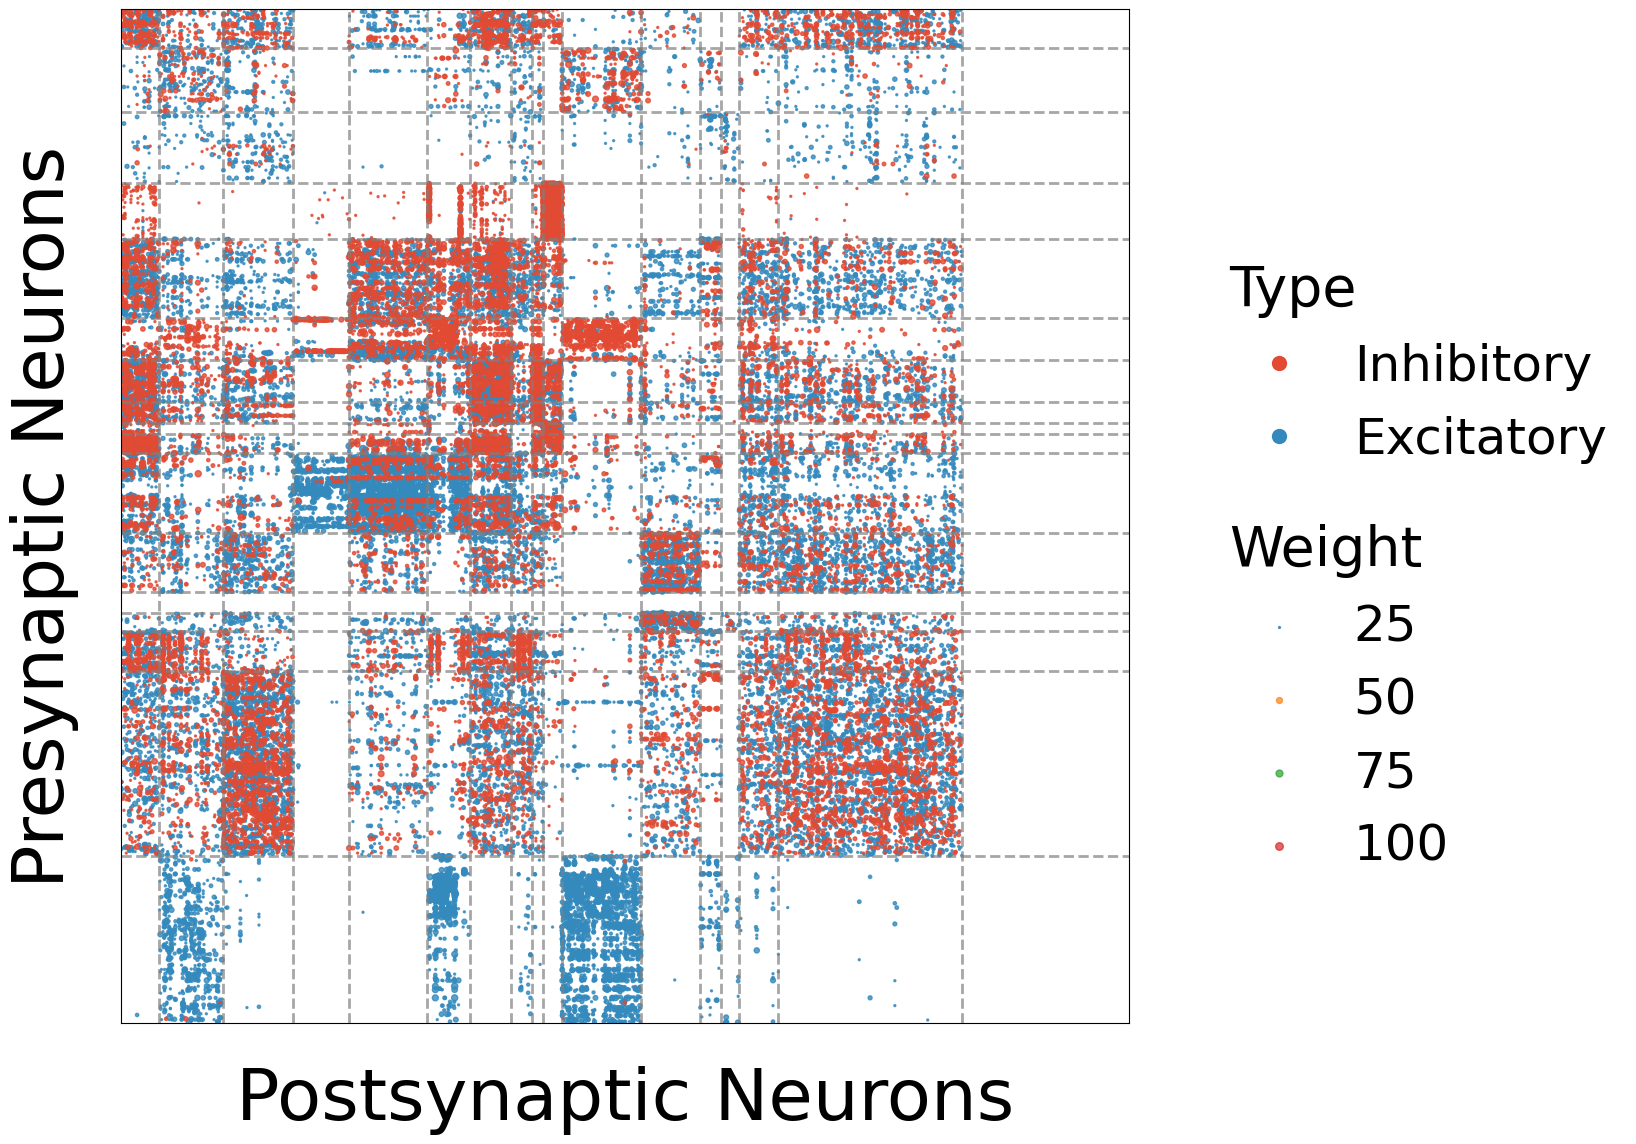

In [8]:
# Project root: parent of current directory when running from notebooks/
PROJECT_ROOT = os.path.dirname(os.getcwd())
connectivity_path = os.path.join(PROJECT_ROOT, 'data', 'connectome_data', 'ad_connectivity_matrix.csv')
annotation_path = os.path.join(PROJECT_ROOT, 'data', 'connectome_data', 'science.add9330_data_s2.csv')
signed_path = os.path.join(PROJECT_ROOT, 'data', 'connectome_data', 'signed_connectivity_matrix.csv')
visualize_connectome_with_dots(
    connectivity_path, annotation_path, signed_path=signed_path, dpi=300)

In [32]:
def load_drosophila_matrix(csv_path, signed=False):
    """
    Load and process a Drosophila connectivity matrix.
    """
    W_df = pd.read_csv(csv_path, index_col=0, header=0)
    W = W_df.values.astype(np.float32)

    # Normalize depending on whether it's signed or unsigned
    if signed:
        max_abs = np.max(np.abs(W))
        W_norm = W / max_abs if max_abs != 0 else W
    else:
        W_min, W_max = W.min(), W.max()
        W_norm = (W - W_min) / (W_max - W_min + 1e-8)

    return W_norm


def load_connectivity_data(
    connectivity_path,
    annotation_path=None,
    celltype_mapping_path=None,
    rescale_factor=4e-2,
    sensory_type="all",
):
    """
    If celltype_mapping is provided (dict node_id->'sensory'/'internal'/'output'),
    use it to split neurons. Otherwise fall back to reading annotation_path.
    """
    # 1) Load connectivity matrix
    df_conn = pd.read_csv(connectivity_path, index_col=0)
    df_conn.index = df_conn.index.astype(int)
    df_conn.columns = df_conn.columns.astype(int)
    df_conn = df_conn * rescale_factor

    all_neuron_ids = sorted(df_conn.index.tolist())

    # 2) Determine sensory/internal/output via mapping or annotation file
    if celltype_mapping_path is not None:
        # use mapping
        celltype_df = pd.read_csv(celltype_mapping_path, index_col="node_id")
        celltype_mapping = celltype_df['celltype'].to_dict()
        sensory_ids_full  = [nid for nid in all_neuron_ids
                             if celltype_mapping.get(nid) == 'sensory']
        internal_ids_full = [nid for nid in all_neuron_ids
                             if celltype_mapping.get(nid) == 'internal']
        output_ids_full   = [nid for nid in all_neuron_ids
                             if celltype_mapping.get(nid) == 'output']
    else:
        raise ValueError("annotation_path logic not shown")

    # 3) filter to valid IDs
    sensory_ids  = [nid for nid in sensory_ids_full  if nid in all_neuron_ids]
    internal_ids = [nid for nid in internal_ids_full if nid in all_neuron_ids]
    output_ids   = [nid for nid in output_ids_full   if nid in all_neuron_ids]

    # 4) build S-I-O ordered adjacency
    ordered_ids = sensory_ids + internal_ids + output_ids
    adjacency   = df_conn.loc[ordered_ids, ordered_ids].values

    # 5) slice into submatrices
    n_s, n_i, n_o = len(sensory_ids), len(internal_ids), len(output_ids)
    W_ss = adjacency[:n_s,    :n_s]
    W_sr = adjacency[:n_s,    n_s:n_s+n_i]
    W_so = adjacency[:n_s,    n_s+n_i:]
    W_rs = adjacency[n_s:n_s+n_i, :n_s]
    W_rr = adjacency[n_s:n_s+n_i, n_s:n_s+n_i]
    W_ro = adjacency[n_s:n_s+n_i, n_s+n_i:]
    W_os = adjacency[n_s+n_i:, :n_s]
    W_or = adjacency[n_s+n_i:, n_s:n_s+n_i]
    W_oo = adjacency[n_s+n_i:, n_s+n_i:]

    return {
        "node_ids":    ordered_ids,
        "W_original":  df_conn.values,
        "W":           adjacency,
        "W_ss":        W_ss, "W_sr": W_sr, "W_so": W_so,
        "W_rs":        W_rs, "W_rr": W_rr, "W_ro": W_ro,
        "W_os":        W_os, "W_or": W_or, "W_oo": W_oo,
        "sensory_ids": sensory_ids,
        "internal_ids":internal_ids,
        "output_ids":  output_ids,
        "sensory_type": sensory_type,
    }


def convert_unsigned_to_signed(sign_csv_path, adjacency_csv_path, out_csv_path):

    df = pd.read_csv(sign_csv_path)
    df["sign"] = df["sign"].apply(
        lambda x: "true" if str(x).strip().lower() == "true" else "false"
    )

    true_count = (df["sign"] == "true").sum()
    total_count = len(df)
    false_count = total_count - true_count
    true_pct = (true_count / total_count * 100) if total_count else 0
    false_pct = 100 - true_pct
    print(f"True sign count: {true_count} ({true_pct:.2f}%)")
    print(f"False sign count: {false_count} ({false_pct:.2f}%)")

    conn_matrix_df = pd.read_csv(adjacency_csv_path, index_col=0)
    conn_matrix_df.to_csv(out_csv_path)
    print(f"Saved signed connectivity matrix to: {out_csv_path}")


def adjacency_spectral_embed(W):
    _, S, _ = randomized_svd(W, n_components=200, n_iter=5, random_state=0)
    d_hat   = max(_infer_dimension(S, W.shape[0]), 2)
    vals, vecs = eigsh(W, k=d_hat, which="LA")
    idx    = np.argsort(vals)[::-1]
    vals   = np.clip(vals[idx], 0, None)
    return vecs[:, idx] * np.sqrt(vals)


def estimate_block_and_theta(W, labels):
    W_abs = np.abs(W)
    theta = W_abs.sum(axis=1)
    K     = labels.max() + 1
    B     = np.zeros((K, K))
    for i in range(K):
        for j in range(K):
            mi, mj = (labels == i), (labels == j)
            denom  = theta[mi].sum() * theta[mj].sum()
            B[i, j] = W_abs[np.ix_(mi, mj)].sum() / denom if denom > 0 else 0.0
    return B, theta

def load_expansion_connectome_data(
    expansion_path: str, rescale_factor: float = 4e-2
) -> tuple[np.ndarray, dict[str, np.ndarray]]:
    """
    Load connectome data from expansion NPZ file

    Args:
        expansion_path: Path to expansion NPZ file (e.g., expansion_5xxx.npz)
        rescale_factor: Factor to rescale the connectivity weights

    Returns:
        Tuple of (weight_matrix, connectivity_dict)

    The expansion NPZ file contains:
    - W_exp: Weight matrix (N x N)
    - z_exp: SIO classification vector where {0: "sensory", 1: "internal", 2: "output"}
    """
    # Load expansion data
    data = np.load(expansion_path)
    W_exp = data["W_exp"].astype(np.float32)
    z_exp = data["z_exp"]
    data.close()

    # Apply rescaling
    W_scaled = W_exp * rescale_factor

    # Extract SIO indices based on z_exp values
    sensory_indices = np.where(z_exp == 0)[0]
    internal_indices = np.where(z_exp == 1)[0]
    output_indices = np.where(z_exp == 2)[0]

    # Create SIO-ordered adjacency matrix
    ordered_indices = np.concatenate(
        [sensory_indices, internal_indices, output_indices]
    )
    adjacency = W_scaled[ordered_indices][:, ordered_indices]

    # Calculate dimensions for each group
    num_sensory = len(sensory_indices)
    num_internal = len(internal_indices)
    num_output = len(output_indices)

    # Extract sub-matrices following the SIO ordering pattern
    W_ss = adjacency[:num_sensory, :num_sensory]
    W_sr = adjacency[:num_sensory, num_sensory : num_sensory + num_internal]
    W_so = adjacency[:num_sensory, num_sensory + num_internal :]

    W_rs = adjacency[num_sensory : num_sensory + num_internal, :num_sensory]
    W_rr = adjacency[
        num_sensory : num_sensory + num_internal,
        num_sensory : num_sensory + num_internal,
    ]
    W_ro = adjacency[
        num_sensory : num_sensory + num_internal, num_sensory + num_internal :
    ]

    W_os = adjacency[num_sensory + num_internal :, :num_sensory]
    W_or = adjacency[
        num_sensory + num_internal :, num_sensory : num_sensory + num_internal
    ]
    W_oo = adjacency[num_sensory + num_internal :, num_sensory + num_internal :]

    # Create connectivity dictionary matching the original format
    conn = {
        "W_original": W_scaled,
        "W": adjacency,  # SIO-ordered matrix
        "W_ss": W_ss,
        "W_sr": W_sr,
        "W_so": W_so,
        "W_rs": W_rs,
        "W_rr": W_rr,
        "W_ro": W_ro,
        "W_or": W_or,
        "W_os": W_os,
        "W_oo": W_oo,
        "sensory_ids": sensory_indices.tolist(),
        "internal_ids": internal_indices.tolist(),
        "output_ids": output_indices.tolist(),
        "sensory_type": "expansion",  # Mark as expansion-based
    }
    
    return adjacency, conn

In [33]:
# Config
PROJECT_ROOT = os.path.dirname(os.getcwd())
signed_path = os.path.join(PROJECT_ROOT, 'data', 'connectome_data', 'signed_connectivity_matrix.csv')
annotation_path = os.path.join(PROJECT_ROOT, 'data', 'connectome_data', 'science.add9330_data_s2.csv')
celltype_mapping_path = os.path.join(PROJECT_ROOT, 'data', 'connectome_data', 'celltype_mapping.csv')
expansion_out_path = os.path.join(PROJECT_ROOT, 'data', 'connectome_data', 'expansion_connectome.npz')
rescale_factor = 4e-2
n_expand = 1

# Load original connectome
data = load_connectivity_data(
    connectivity_path=signed_path,
    annotation_path=annotation_path,
    celltype_mapping_path=celltype_mapping_path,
    rescale_factor=1,
    sensory_type="all",
)
W = data["W"]
node_ids = data["sensory_ids"] + data["internal_ids"] + data["output_ids"]
N0 = W.shape[0]

sensory_set  = set(data["sensory_ids"])
internal_set = set(data["internal_ids"])
z_orig = np.array(
    [0 if nid in sensory_set else 1 if nid in internal_set else 2 for nid in node_ids],
    dtype=int,
)

# Spectral embedding + seeded GMM
X_orig = adjacency_spectral_embed(W)

init_means   = [X_orig[z_orig == k].mean(axis=0)          for k in range(3)]
init_covs    = [np.cov(X_orig[z_orig == k], rowvar=False)  for k in range(3)]
init_weights = [(z_orig == k).sum() / N0                   for k in range(3)]

gm = GaussianMixture(
    n_components=3,
    covariance_type="full",
    weights_init=init_weights,
    means_init=init_means,
    precisions_init=[np.linalg.inv(c) for c in init_covs],
    random_state=0,
).fit(X_orig)

# Sample synthetic node labels and latent vectors
N1      = n_expand * N0
probs   = np.bincount(z_orig, minlength=3) / N0
z_synth = np.random.choice(3, size=N1, replace=True, p=probs)

X_synth = np.zeros((N1, X_orig.shape[1]))
for k in range(3):
    idx = np.where(z_synth == k)[0]
    if idx.size:
        X_synth[idx] = np.random.multivariate_normal(
            gm.means_[k], gm.covariances_[k], size=idx.size
        )

# Sample theta and polarity for synthetic nodes
theta_orig    = np.abs(W).sum(axis=1)
polarity_orig = np.sign(W.sum(axis=1)).astype(int)
polarity_orig[polarity_orig == 0] = 1

theta_synth    = np.zeros(N1)
polarity_synth = np.empty(N1, dtype=int)
for k in range(3):
    idx_o = np.where(z_orig  == k)[0]
    idx_s = np.where(z_synth == k)[0]
    if idx_s.size:
        theta_synth[idx_s]    = np.random.choice(theta_orig[idx_o], size=idx_s.size, replace=True)
        p_ex                  = np.mean(polarity_orig[idx_o] == +1)
        polarity_synth[idx_s] = np.random.choice([+1, -1], size=idx_s.size, p=[p_ex, 1 - p_ex])

# Build full weight matrix
z_all        = np.concatenate([z_orig,        z_synth])
theta_all    = np.concatenate([theta_orig,    theta_synth])
polarity_all = np.concatenate([polarity_orig, polarity_synth])

B_orig, _ = estimate_block_and_theta(W, z_orig)
P         = np.outer(theta_all, theta_all) * B_orig[z_all[:, None], z_all[None, :]]
P         = np.clip(P, 0.0, None)

W_reservoir            = polarity_all[:, None] * np.random.poisson(lam=P)
W_reservoir[:N0, :N0] = W

# Save to NPZ
np.savez(
    expansion_out_path,
    W_exp=W_reservoir.astype(np.float32),
    z_exp=z_all.astype(np.int32),
)
print(f"Saved expansion connectome to {expansion_out_path}")
print(f" Nodes: {W_reservoir.shape[0]}  (original {N0} + synthetic {N1})")
print(f" SIO counts: {np.bincount(z_all, minlength=3)}")


# Reload via load_expansion_connectome_data
adjacency_exp, conn_exp = load_expansion_connectome_data(
    expansion_path=expansion_out_path,
    rescale_factor=rescale_factor,
)



Saved expansion connectome to /cis/home/bxu41/notebooks/TNN_Image_Chess/data/connectome_data/expansion_connectome.npz
 Nodes: 5904  (original 2952 + synthetic 2952)
 SIO counts: [ 859 4624  421]


In [ ]:
class BasicRNN(nn.Module):
    def __init__(self, 
                 W_init,
                 input_dim: int,
                 sensory_dim: int,
                 internal_dim: int,
                 output_dim: int,
                 num_classes: int, 
                 sio: bool = True,
                 trainable: bool = False,
                 dropout_rate: float = 0.2,
                 time_steps: int = 2,
                 ):
        """
        Unifies W_ss, W_sr, W_rs, W_rr, W_ro, W_or, W_so, W_oo, W_os into one
        big matrix W of shape (S+I+O, S+I+O). We'll slice it for sub-blocks.

        Regularization parameters:
        - dropout_rate: Rate for dropout applied to the input layer
        """
        super().__init__()
        
        print(f"BasicRNN init: trainable={trainable}")
        print(f"Regularization: dropout_rate={dropout_rate}")
        
        self.sensory_dim = sensory_dim
        self.internal_dim = internal_dim
        self.output_dim = output_dim
        self.total_dim = sensory_dim + internal_dim + output_dim
        self.sio = sio
        
        self.time_steps = time_steps
        
        print(f"W_init.shape: {W_init.shape}, sensory_dim: {sensory_dim}, "
              f"internal_dim: {internal_dim}, output_dim: {output_dim}")
        assert W_init.shape[0] == self.total_dim
        
        # Store initial weights for similarity comparison
        self.register_buffer('W_init', torch.tensor(W_init, dtype=torch.float32))
        
        # Base weight matrix (DPU weights)
        W_init_tensor = torch.tensor(W_init, dtype=torch.float32)
        if trainable:
            self.W = nn.Parameter(W_init_tensor)
        else:
            self.register_buffer('W', W_init_tensor)

        if self.sio:
            self.input_proj = nn.Linear(input_dim, sensory_dim)
            self.output_layer = nn.Linear(output_dim, num_classes)
        else:
            self.input_proj = nn.Linear(input_dim, self.total_dim)
            self.output_layer = nn.Linear(self.total_dim, num_classes)
            
        self.activation = nn.ReLU()
        
        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout_rate)
    

    def forward(self, x, time_steps=None):
        """
        Forward pass with states S, I, O. We slice the effective W into sub-blocks:
          W_ss, W_sr, W_so, W_rs, W_rr, W_ro, W_os, W_or, W_oo
        """
        if time_steps is None:
            time_steps = self.time_steps

        batch_size, device = x.shape[0], x.device
        
        # Just flatten the input
        x = x.view(batch_size, -1)

        # Get effective weight matrix
        W = self.W

        if self.sio:
            # Partition the effective matrix W
            S, I, O = self.sensory_dim, self.internal_dim, self.output_dim
            W_ss = W[0:S,   0:S]
            W_sr = W[0:S,   S:S+I]
            W_so = W[0:S,   S+I:S+I+O]
            W_rs = W[S:S+I, 0:S]
            W_rr = W[S:S+I, S:S+I]
            W_ro = W[S:S+I, S+I:S+I+O]
            W_os = W[S+I:S+I+O, 0:S]
            W_or = W[S+I:S+I+O, S:S+I]
            W_oo = W[S+I:S+I+O, S+I:S+I+O]

            # Initialize states S, I, O to zero
            S_state = torch.zeros(batch_size, S, device=device)
            I_state = torch.zeros(batch_size, I, device=device)
            O_state = torch.zeros(batch_size, O, device=device)

            # Input projection with dropout
            E = self.dropout(self.input_proj(x))

            for t in range(time_steps):
                # Optionally only inject input every 2 steps
                E_t = E if (t % 2 == 0) else torch.zeros_like(E)

                S_next = self.activation(
                    S_state @ W_ss + E_t + I_state @ W_rs + O_state @ W_os
                )
                I_next = self.activation(
                    I_state @ W_rr + S_state @ W_sr + O_state @ W_or
                )
                O_next = self.activation(
                    O_state @ W_oo + I_state @ W_ro + S_state @ W_so
                )

                S_state, I_state, O_state = S_next, I_next, O_next
                
            return self.output_layer(O_state)
        else:
            # Initialize state to zero
            state = torch.zeros(batch_size, self.total_dim, device=device)
            
            # Input projection with dropout
            E = self.dropout(self.input_proj(x))
            
            for t in range(time_steps):
                # Optionally only inject input every 2 steps
                E_t = E if (t % 2 == 0) else torch.zeros_like(E)
                
                # Update state using the whole matrix W
                state_next = self.activation(
                    state @ W + E_t
                )
                state = state_next
            
            # Use the whole state for output
            return self.output_layer(state)

    def save_model(self, path, filename, metadata=None):
        """
        Save model and its configuration to a file.
        """
        os.makedirs(path, exist_ok=True)
        
        # Save model state
        torch.save(self.state_dict(), os.path.join(path, f'{filename}.pt'))
        
        # Save model configuration (no LoRA, no pruning)
        config = {
            'input_dim': self.input_proj.in_features,
            'sensory_dim': self.sensory_dim,
            'internal_dim': self.internal_dim,
            'output_dim': self.output_dim,
            'num_classes': self.output_layer.out_features,
            'W_init': self.W_init.cpu().numpy(),
            'trainable': isinstance(self.W, nn.Parameter),
            'sensory_type': getattr(self, 'sensory_type', 'visual'),
            'dropout_rate': getattr(self, 'dropout', nn.Dropout(0.2)).p,
        }
        
        with open(os.path.join(path, 'model_config.pkl'), 'wb') as f:
            pickle.dump(config, f)
            
        # Save additional metadata if provided
        if metadata:
            with open(os.path.join(path, 'metadata.pkl'), 'wb') as f:
                pickle.dump(metadata, f)

    @classmethod
    def load_model(cls, path, device=None):
        """
        Load a saved model from a directory.
        """
        # Load model configuration
        with open(os.path.join(path, 'model_config.pkl'), 'rb') as f:
            config = pickle.load(f)
            
        # Update device if provided
        if device:
            config['device'] = device
            
        # Extract parameters
        input_dim = config.get('input_dim')
        sensory_dim = config.get('sensory_dim')
        internal_dim = config.get('internal_dim')
        output_dim = config.get('output_dim')
        num_classes = config.get('num_classes')
        W_init = config.get('W_init')
        trainable = config.get('trainable', False)
        device = config.get('device', 'cpu')
        dropout_rate = config.get('dropout_rate', 0.2)
        
        # Create a new instance with the loaded parameters
        model = cls(
            W_init=W_init,
            input_dim=input_dim,
            sensory_dim=sensory_dim,
            internal_dim=internal_dim,
            output_dim=output_dim,
            num_classes=num_classes,
            trainable=trainable,
            dropout_rate=dropout_rate,
        )
        
        # Load the model state
        model.load_state_dict(torch.load(os.path.join(path, 'model.pt'), map_location=device))
        model.to(device)
        
        # Load additional metadata if available
        metadata_path = os.path.join(path, 'metadata.pkl')
        metadata = None
        if os.path.exists(metadata_path):
            with open(metadata_path, 'rb') as f:
                metadata = pickle.load(f)
                
        return model, metadata

In [ ]:
PROJECT_ROOT = os.path.dirname(os.getcwd())

config_data = {
    "result_path": "results",
    "signed": True,
    "sio": True,
    "fewshot": {
        "enabled": True,
        "samples": 60,
        "batch_size": 17
    },
    "num_trials": 5,
    "num_epochs": 10,
    "batch_size": 64,
    "learning_rate": 0.003,
    "dropout_rate": 0.2,  
    "csv_paths": {
        "signed": "data/connectome_data/signed_connectivity_matrix.csv",
        "unsigned": "data/connectome_data/ad_connectivity_matrix.csv"
    },
    "annotation_path": "data/connectome_data/science.add9330_data_s2.csv",
    "rescale_factor": 0.04,
    "dataset": "mnist",         # Options: "mnist" or "cifar10"
    "experiments": {
        "Unlearnable_RNN": {
            "type": "basicrnn",
            "trainable": False,
            "sensory_type": "all",
            "init": "droso",
            "time_steps": 2
        }, 
    }
    # change here to 
    # "experiments": {
    #     "TwoHiddenMLP": {
    #         "type": "twohiddenmlp",
    #         "trainable": True,
    #         "use_weight_clipping": True,
    #         "freeze": False,
    #     }
    # }

    # "experiments": {
    #     "ThreeHiddenMLP": {
    #         "type": "threehiddenmlp",
    #         "trainable": True,
    #         "use_weight_clipping": True,
    #         "freeze": False,
    #     }

    # }
}


result_path   = os.path.join(PROJECT_ROOT, config_data["result_path"])
signed        = config_data["signed"]
sio           = config_data["sio"]
num_trials    = config_data["num_trials"]
num_epochs    = config_data["num_epochs"]
batch_size    = config_data["batch_size"]
learning_rate = config_data["learning_rate"]
dropout_rate  = config_data.get("dropout_rate", 0.2)
experiments   = config_data["experiments"]

fewshot_cfg        = config_data.get("fewshot", {})
fewshot_enabled    = fewshot_cfg.get("enabled", False)
fewshot_samples    = fewshot_cfg.get("samples", 60)
fewshot_batch_size = fewshot_cfg.get("batch_size", 10)


In [ ]:
if fewshot_enabled:
    fewshot_experiments = {}
    for exp_id, exp_config in experiments.items():
        cfg = exp_config.copy()
        cfg["fewshot"] = fewshot_samples
        cfg["fewshot_batch_size"] = fewshot_batch_size
        fewshot_experiments[f"{exp_id}_fewshot_{fewshot_samples}"] = cfg
    experiments = fewshot_experiments

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def initialize_model(config):
    dataset = config_data.get("dataset", "mnist")
    if dataset == "mnist":
        input_dim = 28 * 28
    elif dataset == "cifar10":
        input_dim = 3 * 32 * 32
    else:
        raise ValueError(f"Unsupported dataset: {dataset}")

    model_type = config["type"]

    if model_type == "basicrnn":
        conn = load_connectivity_data(
            connectivity_path=os.path.join(
                PROJECT_ROOT, config_data["csv_paths"]["signed"]
            ),
            annotation_path=os.path.join(PROJECT_ROOT, config_data["annotation_path"]),
            rescale_factor=config_data.get("rescale_factor"),
            sensory_type=config.get("sensory_type", "all"),
        )
        W_init = conn.get("W")
        if W_init is None:
            W_init = np.block([
                [conn["W_ss"], conn["W_sr"], conn["W_so"]],
                [conn["W_rs"], conn["W_rr"], conn["W_ro"]],
                [conn["W_os"], conn["W_or"], conn["W_oo"]],
            ])
        return BasicRNN(
            W_init=W_init,
            input_dim=input_dim,
            sensory_dim=conn["W_ss"].shape[0],
            internal_dim=conn["W_rr"].shape[0],
            output_dim=conn["W_oo"].shape[0],
            num_classes=10,
            sio=sio,
            trainable=config.get("trainable", False),
            dropout_rate=dropout_rate,
            time_steps=config.get("time_steps", 2),
        )
    elif model_type == "threehiddenmlp":
        return ThreeHiddenMLP(input_dim, 29, 147, 400, 10, config.get("freeze", False))
    elif model_type == "twohiddenmlp":
        return TwoHiddenMLP(
            input_size=input_dim,
            hidden1_size=841,
            hidden2_size=841,
            output_size=10,
            freeze=config.get("freeze", False),
            use_weight_clipping=config.get("use_weight_clipping", True),
            dropout_rate=dropout_rate,
        )
    else:
        raise ValueError(f"Unknown model type: {model_type}")


def train_epoch(model, optimizer, criterion, train_loader):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    pbar = tqdm(train_loader, unit="batch", desc="Training")
    for data, target in pbar:
        data, target = data.squeeze(1).to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            if hasattr(model, "W") and hasattr(model, "W_init"):
                model.W.data.mul_((model.W_init != 0).float())

        total_loss += loss.item() * target.size(0)
        correct    += output.argmax(dim=1).eq(target).sum().item()
        total      += target.size(0)
        pbar.set_postfix(
            loss=f"{loss.item():.4f}",
            train_acc=f"{correct / total:.2%}"
        )

    return total_loss / total, correct / total


def evaluate(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.squeeze(1).to(device), target.to(device)
            output = model(data)
            correct += output.argmax(dim=1).eq(target).sum().item()
            total   += target.size(0)
    return correct / total if total > 0 else 0.0


def _count_nonzero(model):
    result = {}
    for name, submodule in model.named_children():
        result[name] = sum(
            torch.count_nonzero(p).item()
            for p in submodule.parameters(recurse=False)
        )
    result["total"] = sum(torch.count_nonzero(p).item() for p in model.parameters())
    return result


def run_training_loop(model, config, full_train_set, test_loader,
                      exp_id, trial_num, n_epochs, b_size, fs_batch_size):
    results = {
        "epoch_train_loss": [],
        "epoch_train_acc":  [],
        "epoch_test_acc":   [],
        "submodules_nonzero": [],
        "similarity_dict":  [],
    }

    criterion = nn.CrossEntropyLoss()

    if hasattr(model, "W"):
        rnn_lr   = learning_rate * 0.1
        rnn_params   = [model.W]
        other_params = [p for p in model.parameters() if p is not model.W]
        optimizer = optim.AdamW(
            [{"params": rnn_params, "lr": rnn_lr},
             {"params": other_params, "lr": learning_rate}],
            weight_decay=config.get("weight_decay", 1e-4)
        )
    else:
        optimizer = optim.AdamW(
            model.parameters(),
            lr=learning_rate,
            weight_decay=config.get("weight_decay", 1e-4)
        )

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="max",
        factor=config.get("gamma", 0.1),
        patience=config.get("patience", 8),
        min_lr=config.get("min_lr", 0),
    )

    data_loader = DataLoader(
        batch_size=b_size,
        task=config_data.get("dataset", "mnist")
    )
    data_loader.test_sample_limit = config.get("test_samples", 2000)

    init_acc = evaluate(model, test_loader)
    results["epoch_test_acc"].append(init_acc)
    print(f"Trial {trial_num} | Epoch 0 | Test Acc: {init_acc:.2%}")

    is_fewshot = "fewshot" in config

    for epoch in range(n_epochs):
        train_loader = data_loader.get_train_loader(
            full_train_set,
            epoch=epoch if is_fewshot else None,
            fewshot_samples=config.get("fewshot") if is_fewshot else None,
            fewshot_batch_size=config.get("fewshot_batch_size", fs_batch_size) if is_fewshot else None,
        )

        epoch_loss, epoch_acc = train_epoch(model, optimizer, criterion, train_loader)
        results["epoch_train_loss"].append(epoch_loss)
        results["epoch_train_acc"].append(epoch_acc)

        test_acc = evaluate(model, test_loader)
        results["epoch_test_acc"].append(test_acc)

        scheduler.step(test_acc)

        nonzero_dict = _count_nonzero(model)
        results["submodules_nonzero"].append(nonzero_dict)

        print(f"submodule nonzero: {nonzero_dict}")
        print(f"Trial {trial_num} | Epoch {epoch+1}/{n_epochs} "
              f"| Loss {epoch_loss:.4f} | Train {epoch_acc:.2%} | Test {test_acc:.2%}")

    return results



def train_experiment(exp_id, config, trial_num):
    print("=" * 50)
    print(f"Experiment: {exp_id}  |  Trial: {trial_num}")
    for k, v in config.items():
        print(f"  {k}: {v}")
    print("=" * 50)

    torch.manual_seed(trial_num)
    np.random.seed(trial_num)

    data_loader = DataLoader(
        batch_size=batch_size,
        task=config_data.get("dataset", "mnist")
    )
    data_loader.test_sample_limit = config.get("test_samples", 2000)
    full_train_set, test_loader = data_loader.load_data()

    train_samples = config.get("train_samples", None)
    if train_samples is not None and hasattr(full_train_set, "targets"):
        targets    = np.array(full_train_set.targets)
        train_size = min(train_samples, len(targets))
        if train_samples < len(targets):
            sss = StratifiedShuffleSplit(n_splits=1, train_size=train_size, random_state=42)
            indices, _ = next(sss.split(np.zeros_like(targets), targets))
            full_train_set = torch.utils.data.Subset(full_train_set, indices)
        else:
            print(f"[INFO] Using all {len(targets)} training samples.")

    model = initialize_model(config)
    model.to(device)
    print(f">>> {exp_id} trainable params: {count_parameters(model):,}")

    results = run_training_loop(
        model, config, full_train_set, test_loader,
        exp_id, trial_num, num_epochs, batch_size, fewshot_batch_size,
    )
    save_results(exp_id, config, trial_num, results, signed)


def save_results(exp_id, config, trial_num, results, is_signed):
    os.makedirs(result_path, exist_ok=True)
    filename = f"{exp_id}_trial{trial_num}"
    if "train_samples" in config:
        filename += f"_N{config['train_samples']}"
    if not sio:
        filename += ".whole"
    if is_signed:
        filename += ".signed"
    filename += ".pkl"
    filepath = os.path.join(result_path, filename)
    with open(filepath, "wb") as f:
        pickle.dump(results, f)
    print(f"Results saved → {filepath}")


def result_file_exists(run_id, trial_num, config):
    filename = f"{run_id}_trial{trial_num}"
    if "train_samples" in config:
        filename += f"_N{config['train_samples']}"
    if not sio:
        filename += ".whole"
    if signed:
        filename += ".signed"
    filename += ".pkl"
    return os.path.exists(os.path.join(result_path, filename))



In [ ]:
if fewshot_enabled:
    fewshot_experiments = {}
    for exp_id, exp_config in experiments.items():
        cfg = exp_config.copy()
        cfg["fewshot"] = fewshot_samples
        cfg["fewshot_batch_size"] = fewshot_batch_size
        fewshot_experiments[f"{exp_id}_fewshot_{fewshot_samples}"] = cfg
    experiments = fewshot_experiments

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def initialize_model(config):
    dataset = config_data.get("dataset", "mnist")
    if dataset == "mnist":
        input_dim = 28 * 28
    elif dataset == "cifar10":
        input_dim = 3 * 32 * 32
    else:
        raise ValueError(f"Unsupported dataset: {dataset}")

    model_type = config["type"]

    if model_type == "basicrnn":
        conn = load_connectivity_data(
            connectivity_path=os.path.join(
                PROJECT_ROOT, config_data["csv_paths"]["signed"]
            ),
            annotation_path=os.path.join(PROJECT_ROOT, config_data["annotation_path"]),
            rescale_factor=config_data.get("rescale_factor"),
            sensory_type=config.get("sensory_type", "all"),
        )
        W_init = conn.get("W")
        if W_init is None:
            W_init = np.block([
                [conn["W_ss"], conn["W_sr"], conn["W_so"]],
                [conn["W_rs"], conn["W_rr"], conn["W_ro"]],
                [conn["W_os"], conn["W_or"], conn["W_oo"]],
            ])
        return BasicRNN(
            W_init=W_init,
            input_dim=input_dim,
            sensory_dim=conn["W_ss"].shape[0],
            internal_dim=conn["W_rr"].shape[0],
            output_dim=conn["W_oo"].shape[0],
            num_classes=10,
            sio=sio,
            trainable=config.get("trainable", False),
            dropout_rate=dropout_rate,
            time_steps=config.get("time_steps", 2),
        )
    elif model_type == "threehiddenmlp":
        return ThreeHiddenMLP(input_dim, 29, 147, 400, 10, config.get("freeze", False))
    elif model_type == "twohiddenmlp":
        return TwoHiddenMLP(
            input_size=input_dim,
            hidden1_size=841,
            hidden2_size=841,
            output_size=10,
            freeze=config.get("freeze", False),
            use_weight_clipping=config.get("use_weight_clipping", True),
            dropout_rate=dropout_rate,
        )
    else:
        raise ValueError(f"Unknown model type: {model_type}")


def train_epoch(model, optimizer, criterion, train_loader):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    pbar = tqdm(train_loader, unit="batch", desc="Training")
    for data, target in pbar:
        data, target = data.squeeze(1).to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            if hasattr(model, "W") and hasattr(model, "W_init"):
                model.W.data.mul_((model.W_init != 0).float())

        total_loss += loss.item() * target.size(0)
        correct    += output.argmax(dim=1).eq(target).sum().item()
        total      += target.size(0)
        pbar.set_postfix(
            loss=f"{loss.item():.4f}",
            train_acc=f"{correct / total:.2%}"
        )

    return total_loss / total, correct / total


def evaluate(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.squeeze(1).to(device), target.to(device)
            output = model(data)
            correct += output.argmax(dim=1).eq(target).sum().item()
            total   += target.size(0)
    return correct / total if total > 0 else 0.0


def _count_nonzero(model):
    result = {}
    for name, submodule in model.named_children():
        result[name] = sum(
            torch.count_nonzero(p).item()
            for p in submodule.parameters(recurse=False)
        )
    result["total"] = sum(torch.count_nonzero(p).item() for p in model.parameters())
    return result


def run_training_loop(model, config, full_train_set, test_loader,
                      exp_id, trial_num, n_epochs, b_size, fs_batch_size):
    results = {
        "epoch_train_loss": [],
        "epoch_train_acc":  [],
        "epoch_test_acc":   [],
        "submodules_nonzero": [],
        "similarity_dict":  [],
    }

    criterion = nn.CrossEntropyLoss()

    if hasattr(model, "W"):
        rnn_lr   = learning_rate * 0.1
        rnn_params   = [model.W]
        other_params = [p for p in model.parameters() if p is not model.W]
        optimizer = optim.AdamW(
            [{"params": rnn_params, "lr": rnn_lr},
             {"params": other_params, "lr": learning_rate}],
            weight_decay=config.get("weight_decay", 1e-4)
        )
    else:
        optimizer = optim.AdamW(
            model.parameters(),
            lr=learning_rate,
            weight_decay=config.get("weight_decay", 1e-4)
        )

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="max",
        factor=config.get("gamma", 0.1),
        patience=config.get("patience", 8),
        min_lr=config.get("min_lr", 0),
    )

    data_loader = DataLoader(
        batch_size=b_size,
        task=config_data.get("dataset", "mnist")
    )
    data_loader.test_sample_limit = config.get("test_samples", 2000)

    init_acc = evaluate(model, test_loader)
    results["epoch_test_acc"].append(init_acc)
    print(f"Trial {trial_num} | Epoch 0 | Test Acc: {init_acc:.2%}")

    is_fewshot = "fewshot" in config

    for epoch in range(n_epochs):
        train_loader = data_loader.get_train_loader(
            full_train_set,
            epoch=epoch if is_fewshot else None,
            fewshot_samples=config.get("fewshot") if is_fewshot else None,
            fewshot_batch_size=config.get("fewshot_batch_size", fs_batch_size) if is_fewshot else None,
        )

        epoch_loss, epoch_acc = train_epoch(model, optimizer, criterion, train_loader)
        results["epoch_train_loss"].append(epoch_loss)
        results["epoch_train_acc"].append(epoch_acc)

        test_acc = evaluate(model, test_loader)
        results["epoch_test_acc"].append(test_acc)

        scheduler.step(test_acc)

        nonzero_dict = _count_nonzero(model)
        results["submodules_nonzero"].append(nonzero_dict)

        print(f"submodule nonzero: {nonzero_dict}")
        print(f"Trial {trial_num} | Epoch {epoch+1}/{n_epochs} "
              f"| Loss {epoch_loss:.4f} | Train {epoch_acc:.2%} | Test {test_acc:.2%}")

    return results



def train_experiment(exp_id, config, trial_num):
    print("=" * 50)
    print(f"Experiment: {exp_id}  |  Trial: {trial_num}")
    for k, v in config.items():
        print(f"  {k}: {v}")
    print("=" * 50)

    torch.manual_seed(trial_num)
    np.random.seed(trial_num)

    data_loader = DataLoader(
        batch_size=batch_size,
        task=config_data.get("dataset", "mnist")
    )
    data_loader.test_sample_limit = config.get("test_samples", 2000)
    full_train_set, test_loader = data_loader.load_data()

    train_samples = config.get("train_samples", None)
    if train_samples is not None and hasattr(full_train_set, "targets"):
        targets    = np.array(full_train_set.targets)
        train_size = min(train_samples, len(targets))
        if train_samples < len(targets):
            sss = StratifiedShuffleSplit(n_splits=1, train_size=train_size, random_state=42)
            indices, _ = next(sss.split(np.zeros_like(targets), targets))
            full_train_set = torch.utils.data.Subset(full_train_set, indices)
        else:
            print(f"[INFO] Using all {len(targets)} training samples.")

    model = initialize_model(config)
    model.to(device)
    print(f">>> {exp_id} trainable params: {count_parameters(model):,}")

    results = run_training_loop(
        model, config, full_train_set, test_loader,
        exp_id, trial_num, num_epochs, batch_size, fewshot_batch_size,
    )
    save_results(exp_id, config, trial_num, results, signed)


def save_results(exp_id, config, trial_num, results, is_signed):
    os.makedirs(result_path, exist_ok=True)
    filename = f"{exp_id}_trial{trial_num}"
    if "train_samples" in config:
        filename += f"_N{config['train_samples']}"
    if not sio:
        filename += ".whole"
    if is_signed:
        filename += ".signed"
    filename += ".pkl"
    filepath = os.path.join(result_path, filename)
    with open(filepath, "wb") as f:
        pickle.dump(results, f)
    print(f"Results saved → {filepath}")


def result_file_exists(run_id, trial_num, config):
    filename = f"{run_id}_trial{trial_num}"
    if "train_samples" in config:
        filename += f"_N{config['train_samples']}"
    if not sio:
        filename += ".whole"
    if signed:
        filename += ".signed"
    filename += ".pkl"
    return os.path.exists(os.path.join(result_path, filename))



## Results

### CIFAR-10

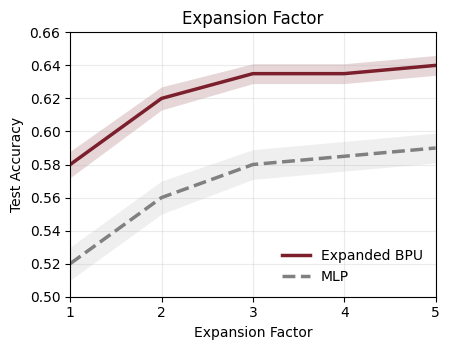

In [3]:
x_exp   = np.array([1, 2, 3, 4, 5], dtype=float)

exp_bpu = np.array([0.580, 0.620, 0.635, 0.635, 0.640])
mlp_exp = np.array([0.520, 0.560, 0.580, 0.585, 0.590])
exp_bpu_se = np.array([0.008, 0.007, 0.006, 0.006, 0.006])
mlp_exp_se = np.array([0.010, 0.010, 0.009, 0.009, 0.009])


def plot_with_band(ax, x, y, se, color, ls, label, band_alpha=0.18, lw=2.5):
    ax.plot(x, y, linestyle=ls, linewidth=lw, color=color, label=label)
    ax.fill_between(x, y - se, y + se, color=color, alpha=band_alpha, linewidth=0)

def format_log_x(ax, xvals):
    ax.set_xscale("log")
    ax.set_xticks(xvals)
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    ax.ticklabel_format(style="plain", axis="x")


fig, ax = plt.subplots(figsize=(4.6, 3.6))
plot_with_band(ax, x_exp, exp_bpu, exp_bpu_se, color="#7a1f2b", ls="-",  label="Expanded BPU", band_alpha=0.18)
plot_with_band(ax, x_exp, mlp_exp, mlp_exp_se, color="gray",     ls="--", label="MLP",          band_alpha=0.12)

ax.set_title("Expansion Factor")
ax.set_xlabel("Expansion Factor")
ax.set_ylabel("Test Accuracy")
ax.set_xticks(x_exp)
ax.set_xlim(1, 5)
ax.set_ylim(0.50, 0.66)
ax.grid(True, alpha=0.25)
ax.legend(frameon=False, loc="lower right")
fig.tight_layout()
fig.show()